## Test of the RINN model on a linear ODE

This notebook is an implementation of the RINN integration scheme given a known linear ODE, it can be used mostly to evaluate the stability of the learnt integration scheme

In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
from scipy.integrate import odeint
from dynamical_models import Lorenz_63, Lorenz_96, oregonator, Adv_Dif_1D
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from utils import RMSE
from tqdm import tqdm
import sympy as sp


In [2]:
# generating training data
class GD:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 10.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train = np.reshape(catalog.true_solution[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Grad_t  = np.reshape(np.gradient(catalog.true_solution[:-10-1,0])/GD.dt_integration,(X_train.shape))
Y_train = np.reshape(catalog.true_solution[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

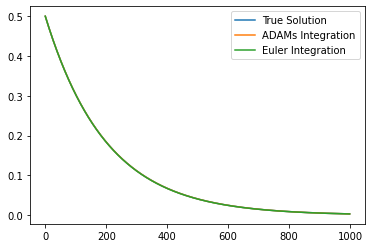

In [3]:
plt.plot(catalog.true_solution[:1000],label = 'True Solution')
plt.plot(catalog.num_integration[:1000],label = 'ADAMs Integration')
plt.plot(catalog.euler_integration[:1000],label = 'Euler Integration')
plt.legend()

In [4]:
#NN parameters 
params = {}
params['lin_coef']= GD.parameters.w
params['dim_input']=1
params['dim_output']=1
params['dim_observations']=1
params['dt_integration']=GD.dt_integration
params['ntrain']=[1000,0,0]
params['order'] = 12
pretrained = False
path = None#'Lin_w=-05.pt'
order= 12#number of stages of the runge kutta scheme

In [5]:
np.random.seed(0)
torch.manual_seed(0)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =params['lin_coef']
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model =  FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params):
            super(INT_net, self).__init__()
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a).double())
            self.b = torch.nn.Parameter(torch.from_numpy(b).double())
            self.c = torch.nn.Parameter(torch.from_numpy(c).double())
            self.Dyn_net = model
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]


# learning the 6 stages RK integration scheme

In [6]:
x = (torch.from_numpy(X_train).double())
y = (torch.from_numpy(Y_train).double())
z = (torch.from_numpy(Grad_t).double())
if pretrained :
    modelRINN.load_state_dict(torch.load(path))
modelRINN = INT_net(params)
criterion = torch.nn.MSELoss(reduction = 'elementwise_mean')
optimizer = torch.optim.Adam(modelRINN.parameters(), lr  = 0.01)
clipper   = applyRK_Constraints()

In [7]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],params['order'])
            pred2 ,grad , inp = modelRINN(pred,params['dt_integration'],params['order'])
            pred3 ,grad , inp = modelRINN(pred2,params['dt_integration'],params['order'])
            pred4 ,grad , inp = modelRINN(pred3,params['dt_integration'],params['order'])
            # Compute and print loss
            loss = criterion(pred, y[b,:,:])+criterion(pred2[:-1,:], pred[1:,:])+criterion(pred3[:-1,:], pred2[1:,:])+criterion(pred4[:-1,:], pred3[1:,:])
            print(t,loss)
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            modelRINN.apply(clipper)

Learning dynamical model
0 tensor(0.0019, dtype=torch.float64, grad_fn=<AddBackward0>)
1 tensor(7.0375e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
2 tensor(7.0145e-12, dtype=torch.float64, grad_fn=<AddBackward0>)


/homes/s17ouala/miniconda3/envs/DYN_ID2/lib/python3.7/site-packages/torch/nn/_reduction.py:14: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


3 tensor(6.9841e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
4 tensor(6.9500e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
5 tensor(6.9138e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
6 tensor(6.8763e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
7 tensor(6.8379e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
8 tensor(6.7989e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
9 tensor(6.7596e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
10 tensor(6.7199e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
11 tensor(6.6801e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
12 tensor(6.6402e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
13 tensor(6.6002e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
14 tensor(6.5602e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
15 tensor(6.5202e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
16 tensor(6.4803e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
17 tensor(6.4405e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
18

130 tensor(3.1233e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
131 tensor(3.1032e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
132 tensor(3.0832e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
133 tensor(3.0633e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
134 tensor(3.0436e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
135 tensor(3.0240e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
136 tensor(3.0045e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
137 tensor(2.9852e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
138 tensor(2.9659e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
139 tensor(2.9468e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
140 tensor(2.9278e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
141 tensor(2.9090e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
142 tensor(2.8902e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
143 tensor(2.8716e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
144 tensor(2.8531e-12, dtype=torch.float64, grad

251 tensor(2.0315e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
252 tensor(2.0186e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
253 tensor(2.0212e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
254 tensor(2.0084e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
255 tensor(2.0109e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
256 tensor(1.9982e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
257 tensor(2.0007e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
258 tensor(1.9880e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
259 tensor(1.9905e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
260 tensor(1.9779e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
261 tensor(1.9804e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
262 tensor(1.9678e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
263 tensor(1.9703e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
264 tensor(1.9578e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
265 tensor(1.9603e-12, dtype=torch.float64, grad

374 tensor(1.4779e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
375 tensor(1.4798e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
376 tensor(1.4703e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
377 tensor(1.4722e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
378 tensor(1.4628e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
379 tensor(1.4647e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
380 tensor(1.4553e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
381 tensor(1.4572e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
382 tensor(1.4479e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
383 tensor(1.4497e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
384 tensor(1.4405e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
385 tensor(1.4423e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
386 tensor(1.4331e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
387 tensor(1.4350e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
388 tensor(1.4258e-12, dtype=torch.float64, grad

497 tensor(1.0819e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
498 tensor(1.0750e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
499 tensor(1.0763e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
500 tensor(1.0694e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
501 tensor(1.0708e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
502 tensor(1.0640e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
503 tensor(1.0653e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
504 tensor(1.0585e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
505 tensor(1.0598e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
506 tensor(1.0531e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
507 tensor(1.0544e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
508 tensor(1.0477e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
509 tensor(1.0490e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
510 tensor(1.0423e-12, dtype=torch.float64, grad_fn=<AddBackward0>)
511 tensor(1.0436e-12, dtype=torch.float64, grad

620 tensor(7.8498e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
621 tensor(7.8598e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
622 tensor(7.8094e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
623 tensor(7.8193e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
624 tensor(7.7692e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
625 tensor(7.7791e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
626 tensor(7.7292e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
627 tensor(7.7390e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
628 tensor(7.6893e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
629 tensor(7.6991e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
630 tensor(7.6498e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
631 tensor(7.6594e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
632 tensor(7.6103e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
633 tensor(7.6200e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
634 tensor(7.5712e-13, dtype=torch.float64, grad

742 tensor(5.7262e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
743 tensor(5.7335e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
744 tensor(5.6966e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
745 tensor(5.7039e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
746 tensor(5.6672e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
747 tensor(5.6744e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
748 tensor(5.6379e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
749 tensor(5.6451e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
750 tensor(5.6088e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
751 tensor(5.6159e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
752 tensor(5.5798e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
753 tensor(5.5869e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
754 tensor(5.5510e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
755 tensor(5.5580e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
756 tensor(5.5223e-13, dtype=torch.float64, grad

864 tensor(4.1732e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
865 tensor(4.1785e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
866 tensor(4.1516e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
867 tensor(4.1568e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
868 tensor(4.1300e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
869 tensor(4.1353e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
870 tensor(4.1087e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
871 tensor(4.1139e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
872 tensor(4.0874e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
873 tensor(4.0926e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
874 tensor(4.0662e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
875 tensor(4.0713e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
876 tensor(4.0451e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
877 tensor(4.0503e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
878 tensor(4.0242e-13, dtype=torch.float64, grad

987 tensor(3.0426e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
988 tensor(3.0230e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
989 tensor(3.0268e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
990 tensor(3.0073e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
991 tensor(3.0111e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
992 tensor(2.9916e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
993 tensor(2.9954e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
994 tensor(2.9761e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
995 tensor(2.9799e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
996 tensor(2.9606e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
997 tensor(2.9644e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
998 tensor(2.9453e-13, dtype=torch.float64, grad_fn=<AddBackward0>)
999 tensor(2.9490e-13, dtype=torch.float64, grad_fn=<AddBackward0>)


# Test on a different integration timestep dt = 2

In [8]:
#forecasting 
tmp = np.reshape(0.5,(1,1))
nb_steps_pred = 2000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(0.5,(1,1))
tmp = (torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,params['dt_integration'],order)[0].data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).double())

RMSE true solution vs Euler :  0.00027953167029904274
RMSE true solution vs RINN  :  0.0007895487168670098


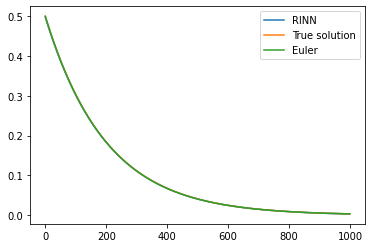

In [9]:
test_dt = 1
dt_ratio = int(test_dt/GD.dt_integration)
length_pred = 1000
plt.plot(y_pred[:length_pred],label = 'RINN')
plt.plot(catalog.true_solution[:length_pred],label = 'True solution')
plt.plot(catalog.euler_integration[:length_pred],label = 'Euler')
plt.legend()
print('RMSE true solution vs Euler : ', RMSE(catalog.true_solution[:length_pred],catalog.euler_integration[:length_pred]))
print('RMSE true solution vs RINN  : ', RMSE(catalog.true_solution[:length_pred],y_pred[:length_pred]))

# Stability analysis of the integration scheme with respect to Euler and RK4 schemes : 

We need first to write the integration scheme as $x_{t+1} = G(h) x{t}$ where $G$ is the gain matrix (here scalar since we are working in 1D).

if G<1  : the integration scheme is stable 
if G=>1 : the integration scheme is unstable
G = 1 when the integration time step = 0

In [10]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h = sp.symbols('xt h')

In [11]:
# computing analytic form of the integration scheme
k = [(modelRINN.Dyn_net.forward(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net.forward(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [12]:
# RK4 analytic integration scheme
grad = modelRINN.Dyn_net.forward(xt)
k1   = modelRINN.Dyn_net.forward(xt)
k2   = modelRINN.Dyn_net.forward(xt+0.5*h*k1)
k3   = modelRINN.Dyn_net.forward(xt+0.5*h*k2)
k4   = modelRINN.Dyn_net.forward(xt+h*k3)            
xt_1RK4 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK4 = xt_1RK4.factor(xt)/xt

In [13]:
xt, h, l = sp.symbols('xt h l')

# RK4 analytic integration scheme
grad = l*xt
k1   = l*xt
k2   = l*(xt+0.5*h*k1)
k3   = l*(xt+0.5*h*k2)
k4   = l*(xt+h*k3)            
xt_1RK42 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK42 = xt_1RK42.factor(xt)/xt

In [14]:
# stability graph
hi = np.arange(0,10+0.000001,GD.dt_integration)
gainRK4 = np.zeros_like(hi)
for i in range(len(hi)):
    gainRK4[i] = np.abs(gRK4.evalf(subs={h: hi[i]}))
gainE = np.zeros_like(hi)
for i in range(len(hi)):
    gainE[i] = np.abs(1-0.5*hi[i])
gain = np.zeros_like(hi)
for i in range(len(hi)):
    gain[i] = np.abs(g.evalf(subs={h: hi[i]}))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


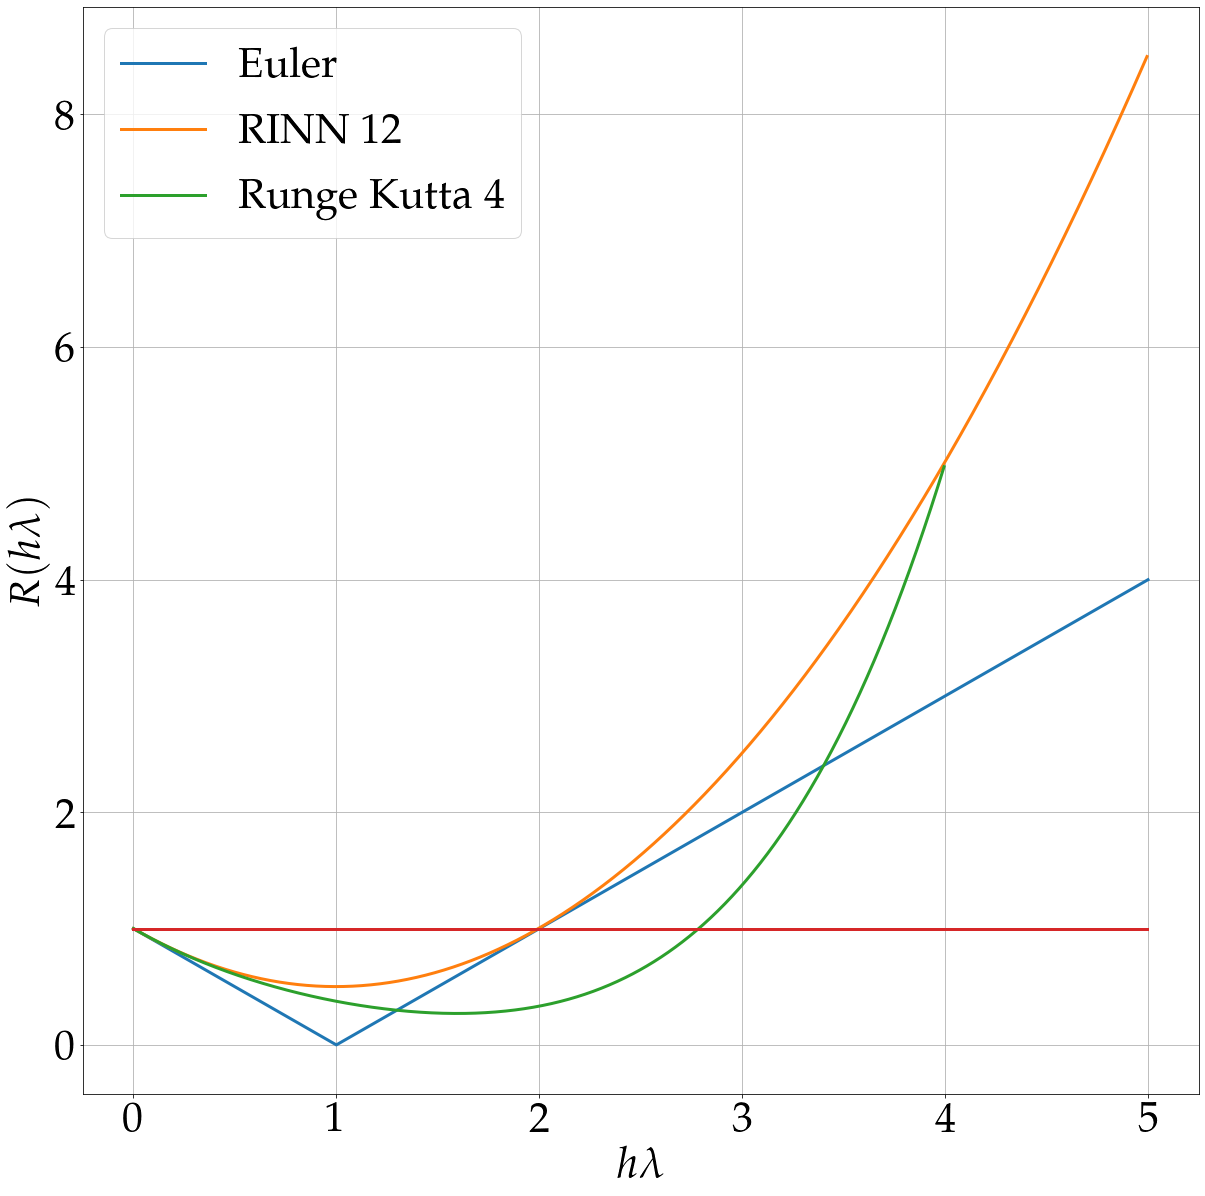

In [15]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:]*0.5,gainE[:],label = 'Euler',lw = 3)
plt.plot(hi[:length_h]*0.5,gain[:length_h],label = 'RINN 12',lw = 3)
plt.plot(hi[:length_h-200]*0.5,gainRK4[:length_h-200],label = 'Runge Kutta 4',lw = 3)
plt.plot(hi[:length_h]*0.5,np.ones_like(gainRK4[:length_h]),lw = 3)
#plt.plot(hi[:600],np.abs(ff[-1].data.numpy()[:600]))
plt.xlabel('$h\lambda$')
plt.ylabel('$R(h\lambda)$')
plt.grid()
plt.legend()


# Analytical expression of the gain R($\lambda$ h) as a 12 th order polynomial 

In [16]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h, lam = sp.symbols('xt h \lambda')
k = [lam*xt]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((lam*(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [17]:
g

1.3012295545154e-54*\lambda**12*h**12 + 2.62288445249935e-39*\lambda**11*h**11 + 1.89734522474062e-33*\lambda**10*h**10 + 1.34067787087126e-28*\lambda**9*h**9 + 4.33484759234097e-24*\lambda**8*h**8 + 8.25507807085541e-20*\lambda**7*h**7 + 1.02391817377575e-15*\lambda**6*h**6 + 8.60206748383249e-12*\lambda**5*h**5 + 4.94472027789873e-8*\lambda**4*h**4 + 0.000192174172107419*\lambda**3*h**3 + 0.501687201543275*\lambda**2*h**2 + 1.0*\lambda*h + 1.0

In [18]:
gRK42

0.0416666666666667*h**4*l**4 + 0.166666666666667*h**3*l**3 + 0.5*h**2*l**2 + h*l + 1.0

# Optimization of the integration scheme to be stable in a given integration timestep range, including RK constraints

In [19]:
# Defining the integration gain class and the gain optimization loss
class Gain(torch.nn.Module):
    def __init__(self):
        super(Gain, self).__init__()
        self.Pred_net_RINN = modelRINN

    def forward(self, h_int, inp, order):
        gain = Variable(torch.zeros(h_int.size()).double())
        for i in range(h_int.shape[0]):
            pred ,tmp, tmpp =self.Pred_net_RINN(inp, h_int[i], order)
            gain[i] = tmpp
            del pred, tmp, tmpp
        return gain
model_int = Gain()

def customized_loss(x, y):
        gain_to_zero = ((x-y+0.2))**2
        return torch.mean(gain_to_zero)
    
x = Variable(torch.from_numpy(X_train).double())
y = Variable(torch.from_numpy(Y_train).double())
z = Variable(torch.from_numpy(Grad_t).double())
hi = np.arange(0,10+0.000001,0.1)
h_int = Variable(torch.from_numpy(hi).double())
gain_true = Variable(torch.from_numpy(np.ones_like(h_int)).double())

# Without enforcing the RK constraints

In [20]:
params['ntrain'][2] = 10
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_int.parameters(), lr = 0.001)   
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,factor=0.1, patience=5, threshold=0.0, threshold_mode='rel', cooldown=0, min_lr=0.00001)
loss_hist = []        
print ('optim integration model')
for t in range(params['ntrain'][2]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted gradients by passing x to the model
        gain_op = model_int(h_int, x[b,:,:],order)
        # Compute and print loss
        loss = customized_loss((gain_op), gain_true)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        print(t,loss)
    lr_scheduler.step(loss.item())

optim integration model
0 tensor(9.3044, dtype=torch.float64, grad_fn=<MeanBackward0>)
1 tensor(8.5029, dtype=torch.float64, grad_fn=<MeanBackward0>)
2 tensor(7.7595, dtype=torch.float64, grad_fn=<MeanBackward0>)
3 tensor(7.0717, dtype=torch.float64, grad_fn=<MeanBackward0>)
4 tensor(6.4366, dtype=torch.float64, grad_fn=<MeanBackward0>)
5 tensor(5.8517, dtype=torch.float64, grad_fn=<MeanBackward0>)
6 tensor(5.3140, dtype=torch.float64, grad_fn=<MeanBackward0>)
7 tensor(4.8208, dtype=torch.float64, grad_fn=<MeanBackward0>)
8 tensor(4.3693, dtype=torch.float64, grad_fn=<MeanBackward0>)
9 tensor(3.9567, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [21]:
#forecasting 
#forecasting 
tmp = np.reshape(0.5,(1,1))
nb_steps_pred = 2000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(0.5,(1,1))
tmp = (torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,5.0,order)[0].data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

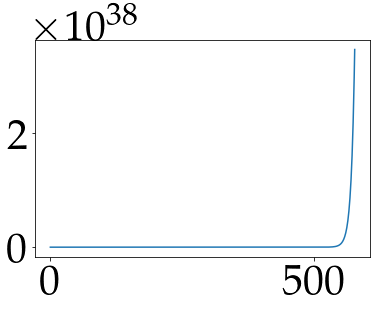

In [22]:
plt.plot(y_pred)

In [23]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h = sp.symbols('xt h')
k = [(modelRINN.Dyn_net.forward(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net.forward(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [24]:
hi = np.arange(0,10+0.000001,GD.dt_integration)
gain_opti = np.zeros_like(hi)
for i in range(len(hi)):
    gain_opti[i] = np.abs(g.evalf(subs={h: hi[i]}))

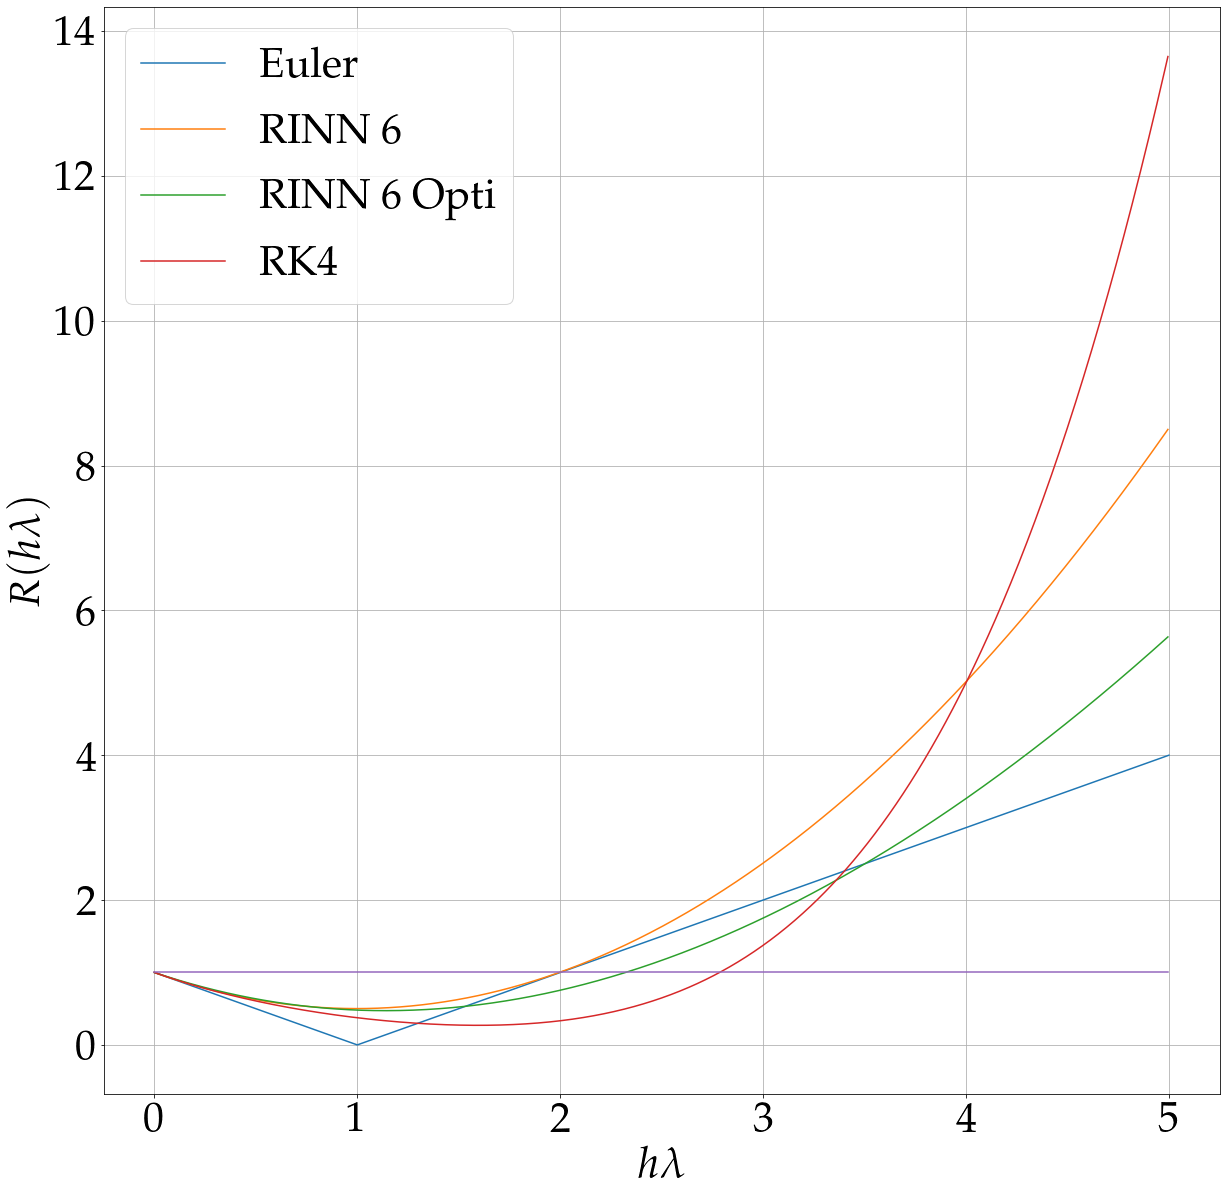

In [25]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:]*0.5,gainE[:],label = 'Euler')
plt.plot(hi[:length_h]*0.5,gain[:length_h],label = 'RINN 6')
plt.plot(hi[:length_h]*0.5,gain_opti[:length_h],label = 'RINN 6 Opti')
plt.plot(hi[:length_h]*0.5,gainRK4[:length_h],label = 'RK4')
plt.plot(hi[:length_h]*0.5,np.ones_like(gainRK4[:length_h]))
plt.xlabel('$h\lambda$')
plt.ylabel('$R(h\lambda)$')
plt.grid()
plt.legend()

In [26]:
modelRINN.b.sum() # RK constraint not respected :/

tensor(0.9420, dtype=torch.float64, grad_fn=<SumBackward0>)

In [27]:
g

1.12359486429791e-27*h**12 - 3.30931785905788e-24*h**11 + 5.98832003665047e-21*h**10 - 6.45386403024204e-18*h**9 + 4.30288311272714e-15*h**8 - 1.88078380818019e-12*h**7 + 5.61840915721844e-10*h**6 - 1.17148554708133e-7*h**5 + 1.70782790575357e-5*h**4 - 0.00170138181625846*h**3 + 0.108978314842208*h**2 - 0.471014330973568*h + 1.0

In [28]:
# With enforcing the RK constraints

In [29]:
clipper = applyRK_Constraints()  
params['ntrain'][2] = 100
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_int.parameters(), lr = 0.005)  
loss_hist = []        
print ('optim integration model')
for t in range(params['ntrain'][2]):
    for b in range(x.shape[0]):
        # Forward pass: Compute predicted gradients by passing x to the model
        gain_op = model_int(h_int, x[b,:,:],order)
        # Compute and print loss
        loss = customized_loss((gain_op), gain_true)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        model_int.Pred_net_RINN.apply(clipper)
        print(t,loss)


optim integration model
0 tensor(3.5804, dtype=torch.float64, grad_fn=<MeanBackward0>)
1 tensor(2.8015, dtype=torch.float64, grad_fn=<MeanBackward0>)
2 tensor(1.6309, dtype=torch.float64, grad_fn=<MeanBackward0>)
3 tensor(0.8826, dtype=torch.float64, grad_fn=<MeanBackward0>)
4 tensor(0.4503, dtype=torch.float64, grad_fn=<MeanBackward0>)
5 tensor(0.2521, dtype=torch.float64, grad_fn=<MeanBackward0>)
6 tensor(0.1813, dtype=torch.float64, grad_fn=<MeanBackward0>)
7 tensor(0.1982, dtype=torch.float64, grad_fn=<MeanBackward0>)
8 tensor(0.2676, dtype=torch.float64, grad_fn=<MeanBackward0>)
9 tensor(0.3516, dtype=torch.float64, grad_fn=<MeanBackward0>)
10 tensor(0.4456, dtype=torch.float64, grad_fn=<MeanBackward0>)
11 tensor(0.5246, dtype=torch.float64, grad_fn=<MeanBackward0>)
12 tensor(0.5908, dtype=torch.float64, grad_fn=<MeanBackward0>)
13 tensor(0.6360, dtype=torch.float64, grad_fn=<MeanBackward0>)
14 tensor(0.6595, dtype=torch.float64, grad_fn=<MeanBackward0>)
15 tensor(0.6626, dtype=to

In [30]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h = sp.symbols('xt h')
k = [(modelRINN.Dyn_net.forward(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net.forward(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [31]:
hi = np.arange(0,20+0.000001,GD.dt_integration)
gain_opti_const = np.zeros_like(hi)
for i in range(len(hi)):
    gain_opti_const[i] = np.abs(g.evalf(subs={h: hi[i]}))

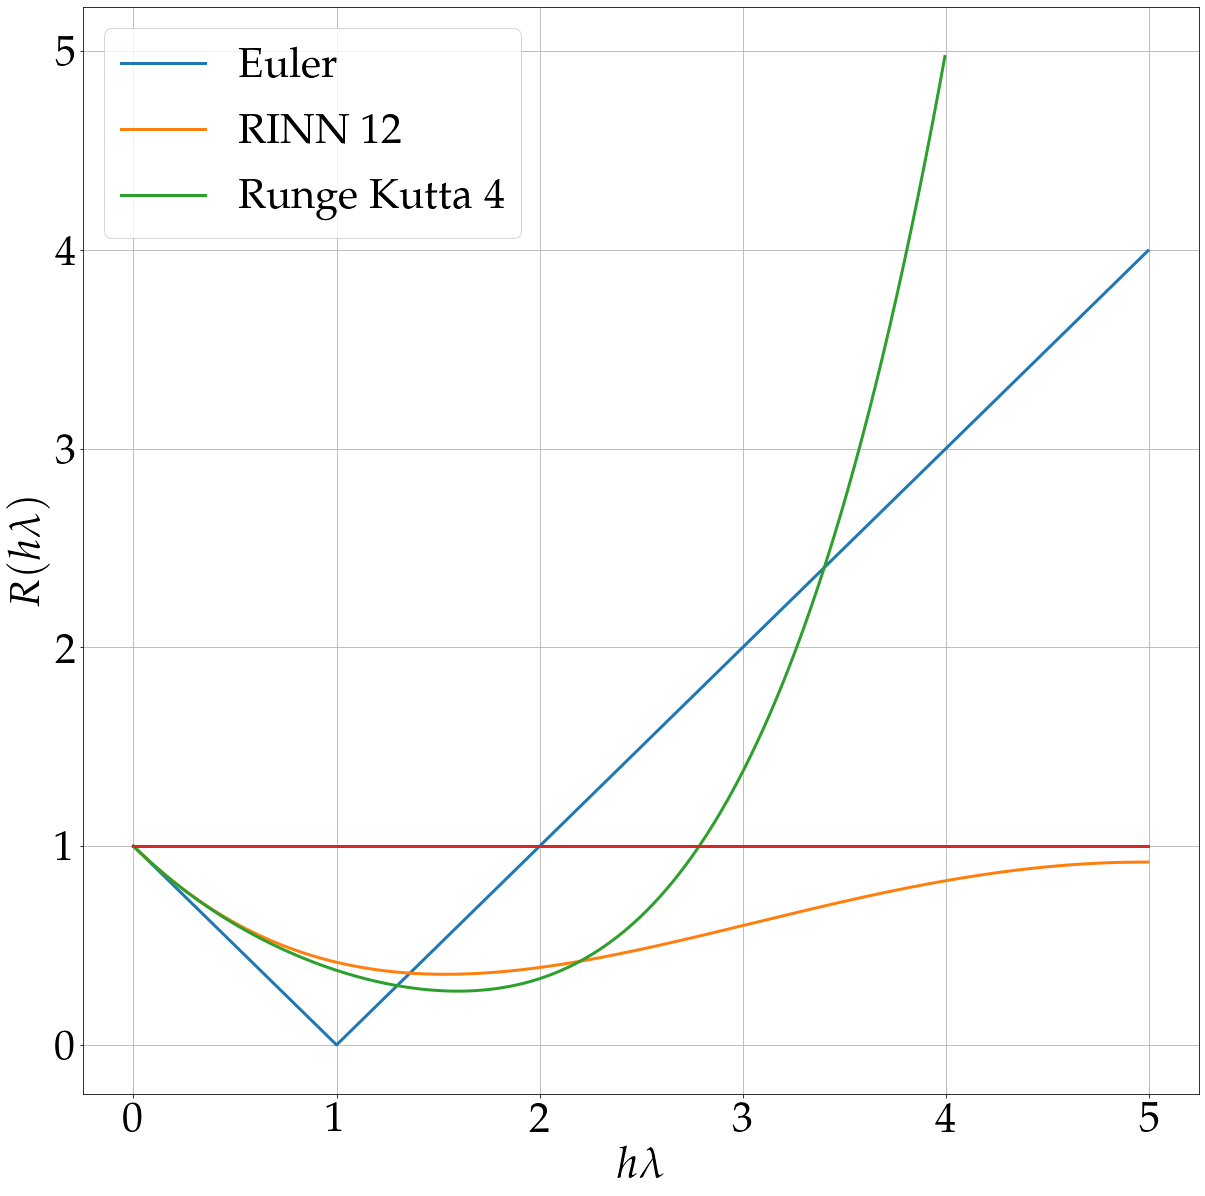

In [32]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:length_h]*0.5,gainE[:length_h],label = 'Euler',lw = 3)
plt.plot(hi[:length_h]*0.5,gain_opti_const[:length_h],label = 'RINN 12',lw = 3)
plt.plot(hi[:length_h-200]*0.5,gainRK4[:length_h-200],label = 'Runge Kutta 4',lw = 3)
plt.plot(hi[:length_h]*0.5,np.ones_like(gainRK4[:length_h]),lw = 3)
#plt.plot(hi[:600],np.abs(ff[-1].data.numpy()[:600]))
plt.xlabel('$h\lambda$')
plt.ylabel('$R(h\lambda)$')
plt.grid()
plt.legend()

In [33]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h, lam = sp.symbols('xt h \lambda')
k = [lam*xt]
att = np.zeros_like(a)

for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                att[:,i,j] = c[:,i]
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                att[:,i,j] = c[:,i]-a[:,i,1:i].sum(1)
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            att[:,i,j] = a[:,i,j]
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((lam*(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [34]:
c[0,i]

1.0

In [35]:
g

1.04806571564434e-17*\lambda**12*h**12 + 1.86334980547649e-17*\lambda**11*h**11 - 2.6145801130237e-13*\lambda**10*h**10 - 2.95552823139072e-11*\lambda**9*h**9 - 8.22098830764841e-10*\lambda**8*h**8 + 6.89718608836753e-8*\lambda**7*h**7 + 6.96899673572071e-6*\lambda**6*h**6 + 0.000283763970552842*\lambda**5*h**5 + 0.00650369208253223*\lambda**4*h**4 + 0.0859863042004135*\lambda**3*h**3 + 0.49546166405387*\lambda**2*h**2 + 1.0*\lambda*h + 1.0

# Stability region of 2D equation

In [36]:
# generating training data (complex)
class GD:
    model = 'Adv_Dif_1D'
    class parameters:
        w = -0.1+1.0j
        x0 = 0.5+0.5j
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 60.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train_r = np.reshape(catalog.true_solution.real[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
X_train_i = np.reshape(catalog.true_solution.imag[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_r = np.reshape(catalog.true_solution.real[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_i = np.reshape(catalog.true_solution.imag[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

In [37]:
#extracting integration scheme params
a=modelRINN.a.clone().detach().data.numpy()[0,:,:]
b=modelRINN.b.clone().detach().data.numpy()[0,:]
c=modelRINN.c.clone().detach().data.numpy()[0,:]

a[:,0] = c[:] - a[:,:].sum(axis = 1)

x1,re_w,h  = sp.symbols('x1 re_w h',real=True)
x2,im_w    = sp.symbols('x2 im_w',real=True)

xt   = sp.symbols('x1+ix2')
lamb = re_w+sp.I*im_w

In [38]:
rz = np.arange(-10,10+0.000001,0.01)
iz = np.arange(-10,10+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [39]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 2001/2001 [04:16<00:00,  7.81it/s]


In [40]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:09<00:00, 204.30it/s]


In [41]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])
crk4 = np.array([0,1/2,1/2,1])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [02:14<00:00, 14.86it/s]


Text(0, 0.5, '$Imag(h\\lambda)$')

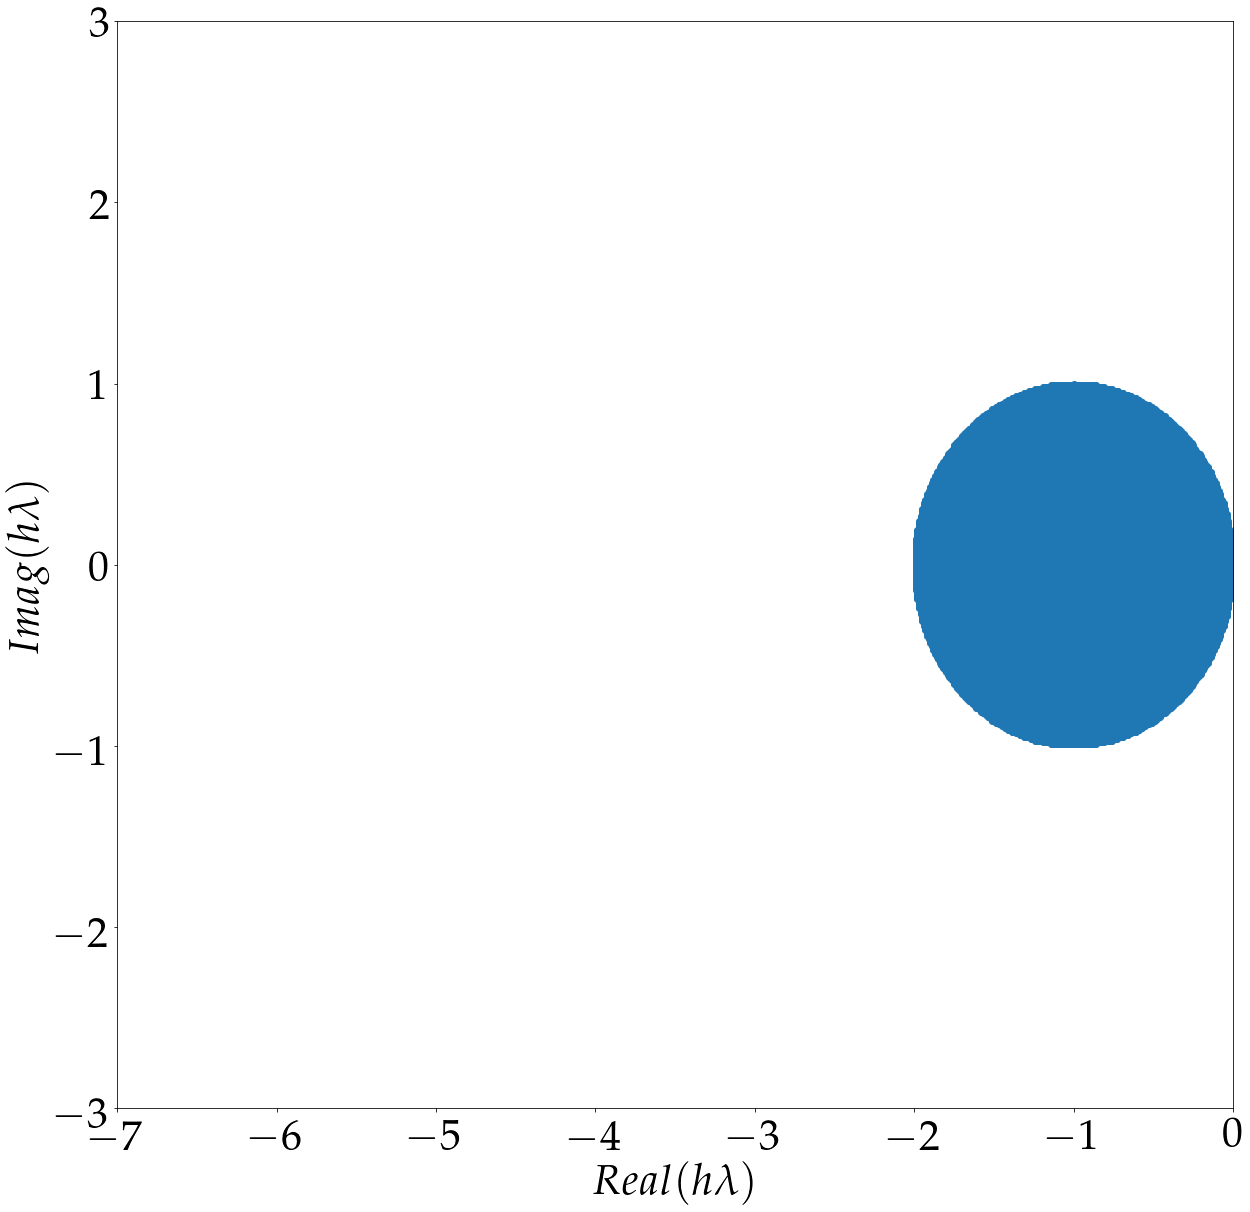

In [42]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_xE),np.array(list_yE))
plt.plot(-hi[:399]*0.5,np.zeros_like(gainE[:length_h][np.where(gainE[:length_h]<1)]),lw = 3)
plt.xlim(-7,0)
plt.ylim(-3,3)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')


(-3.0, 3.0)

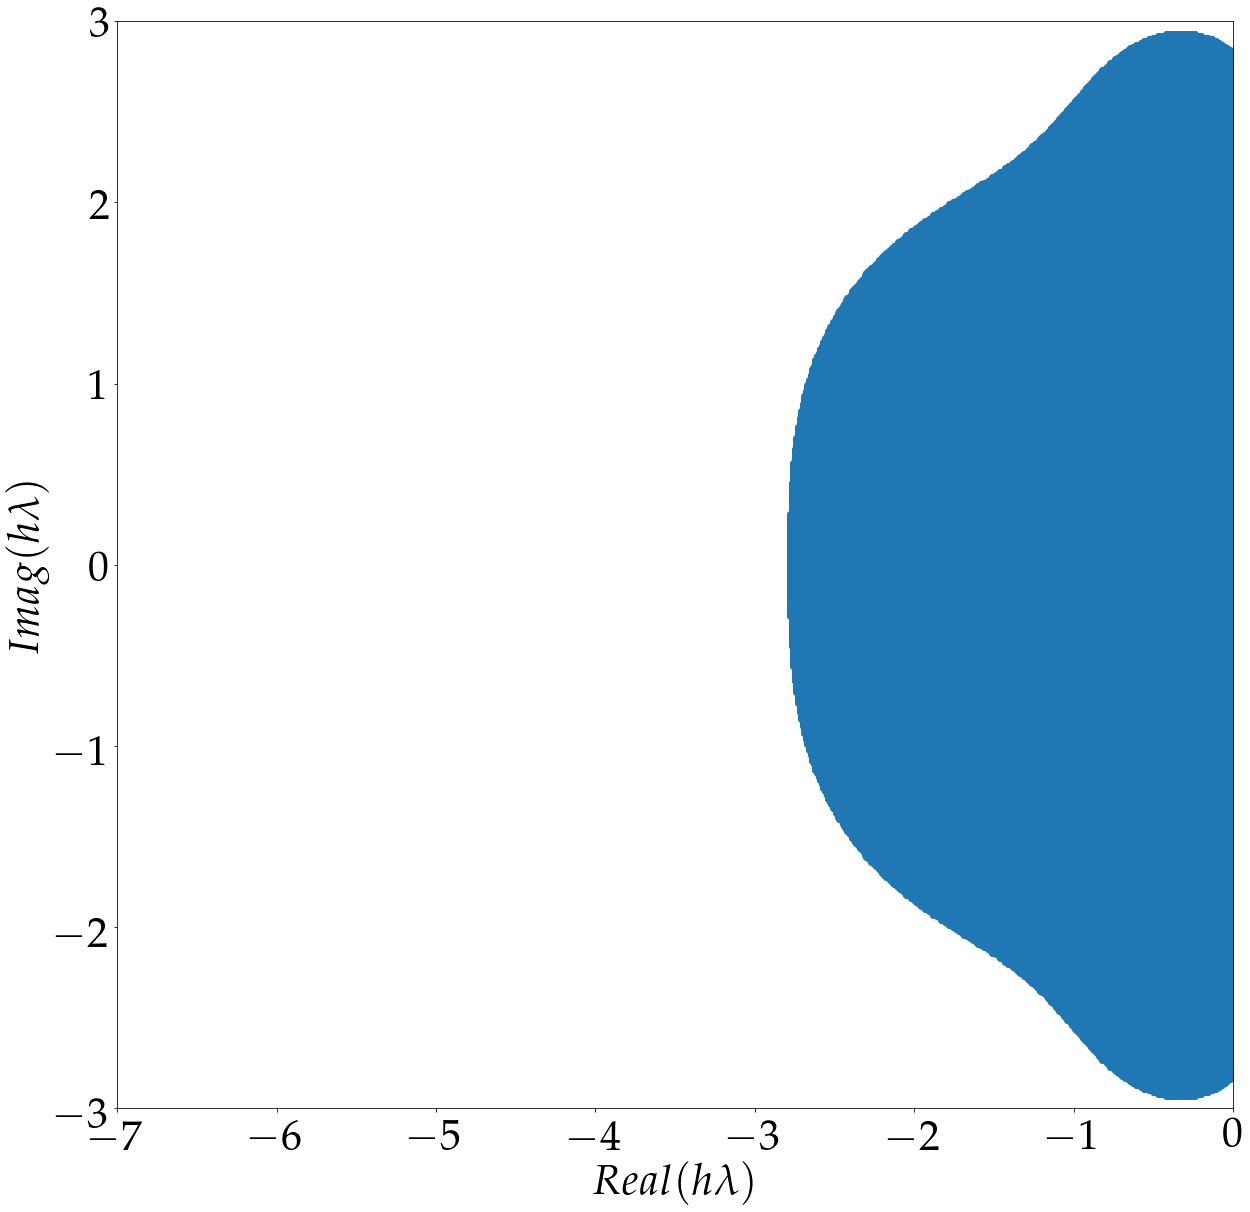

In [43]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_xRK4),np.array(list_yRK4))
plt.plot(-hi[:557]*0.5,np.zeros_like(gainRK4[:length_h][np.where(gainRK4[:length_h]<1)]),lw = 3)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-7,0)
plt.ylim(-3,3)


(-3.0, 3.0)

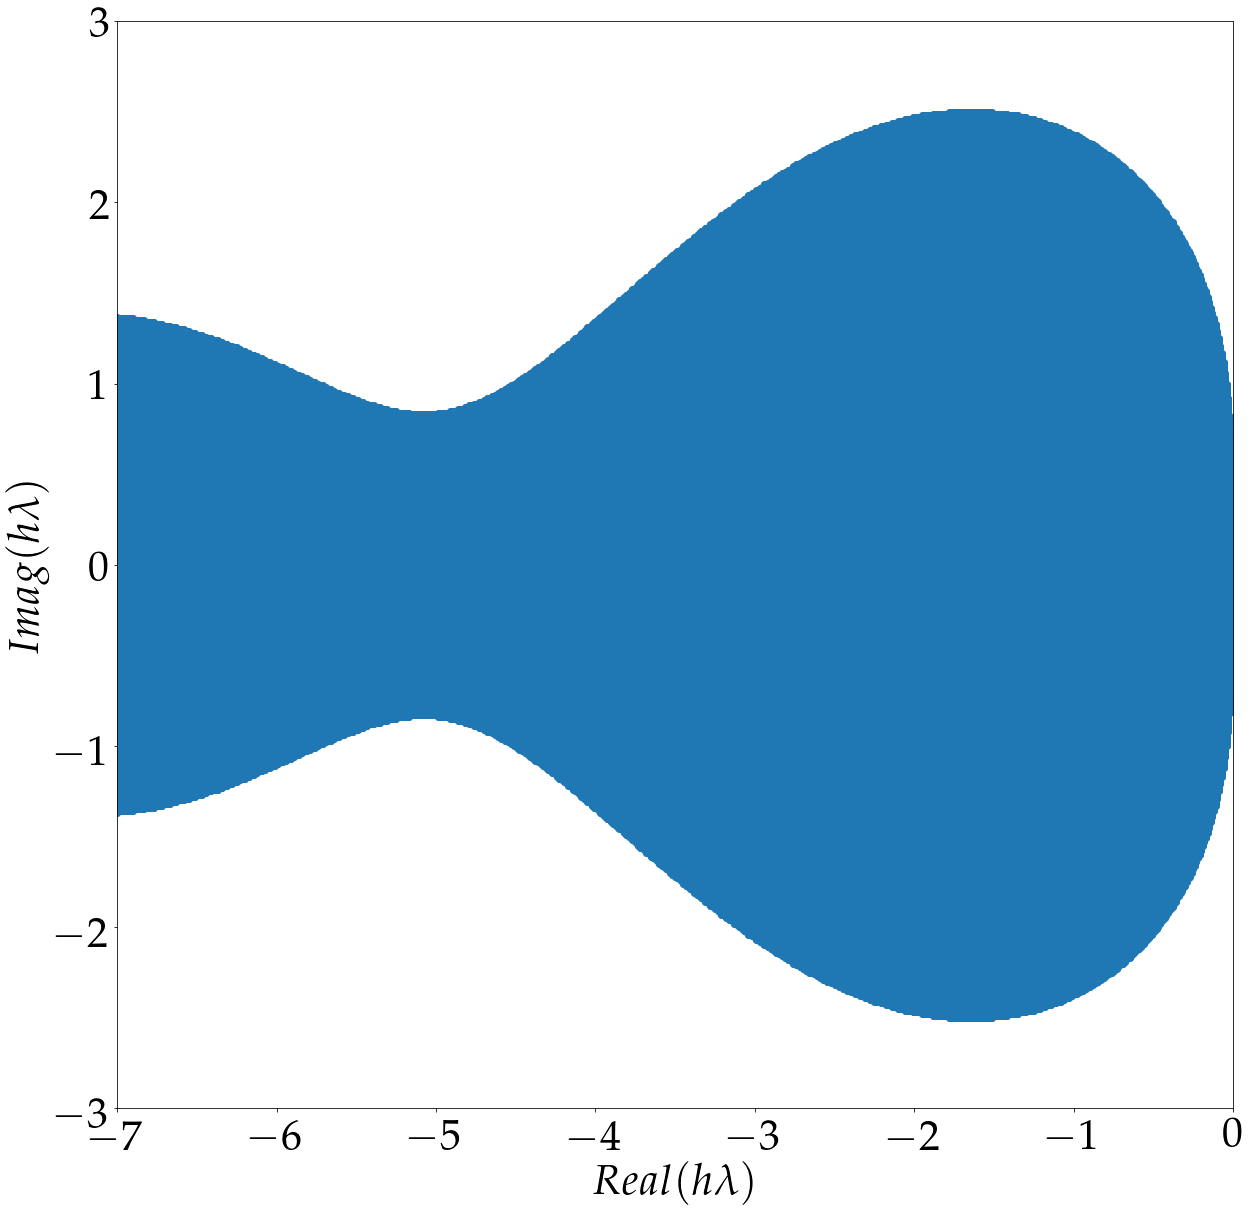

In [44]:
length_h = 1000
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_x),np.array(list_y))
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-7,0)
plt.ylim(-3,3)


# Testing the Trained Integration scheme on the Non-Linear 96 equation

In [45]:
# Lorenz 63 and 96 classes
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            arg = [10.0, 28.0, 8.0/3]
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = arg[0]*(inp[:,1]-inp[:,0]);
            grad[:,1] = inp[:,0]*(arg[1]-inp[:,2])-inp[:,1];
            grad[:,2] = inp[:,0]*inp[:,1] - arg[2]*inp[:,2];
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return grad
model_true  = FC_net_true(params)

class FC_net_true_L96(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true_L96, self).__init__()
        def forward(self, S):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            J = 40
            F = 8
            x = torch.zeros(S.shape[0],J);
            x[:,0] = (S[:,1]-S[:,J-2])*S[:,J-1]-S[:,0];
            x[:,1] = (S[:,2]-S[:,J-1])*S[:,0]-S[:,1];
            x[:,J-1] = (S[:,0]-S[:,J-3])*S[:,J-2]-S[:,J-1];
            for j in range(2,J-1):
                x[:,j] = (S[:,j+1]-S[:,j-2])*S[:,j-1]-S[:,j];
            dS = x + F;
            return dS
model_true_L96  = FC_net_true_L96(params)

In [46]:
# Global class with both the Lorenz 63 and 96 models, implemented with the RK45 and the RINN integration schemes
class INT_net_NL(torch.nn.Module):
        def __init__(self):
            super(INT_net_NL, self).__init__()
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = modelRINN.a
            self.b = modelRINN.b
            self.c = modelRINN.c
            self.Dyn_net_L96 = model_true_L96
            self.Dyn_net_L63 = model_true

        def flow_RINN_True_Model_L96(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_L96(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_L96(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_RINN_True_Model_L63(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_L63(inp))]
            for i in range(1,order):
                coef_sum = torch.zeros(k[0].size())
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_L63(rk_inp))
            pred_sum = torch.zeros(k[0].size())
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_RK45_True_Model_L96(self, inp,dt,order = 4):
            k1    = self.Dyn_net_L96(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_L96(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_L96(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_L96(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1    
        def flow_RK45_L63(self, inp,dt,order = 4):
            k1    = self.Dyn_net_L63(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_L63(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_L63(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_L63(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
modelRINN_NL = INT_net_NL()

In [47]:
nb_steps_pred = 400
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,40))
tmp = np.ones((1,40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp[0,20:] = 1+0.01
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN_NL.flow_RINN_True_Model_L96(tmp,0.05,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,40))).float())

<Figure size 360x360 with 0 Axes>

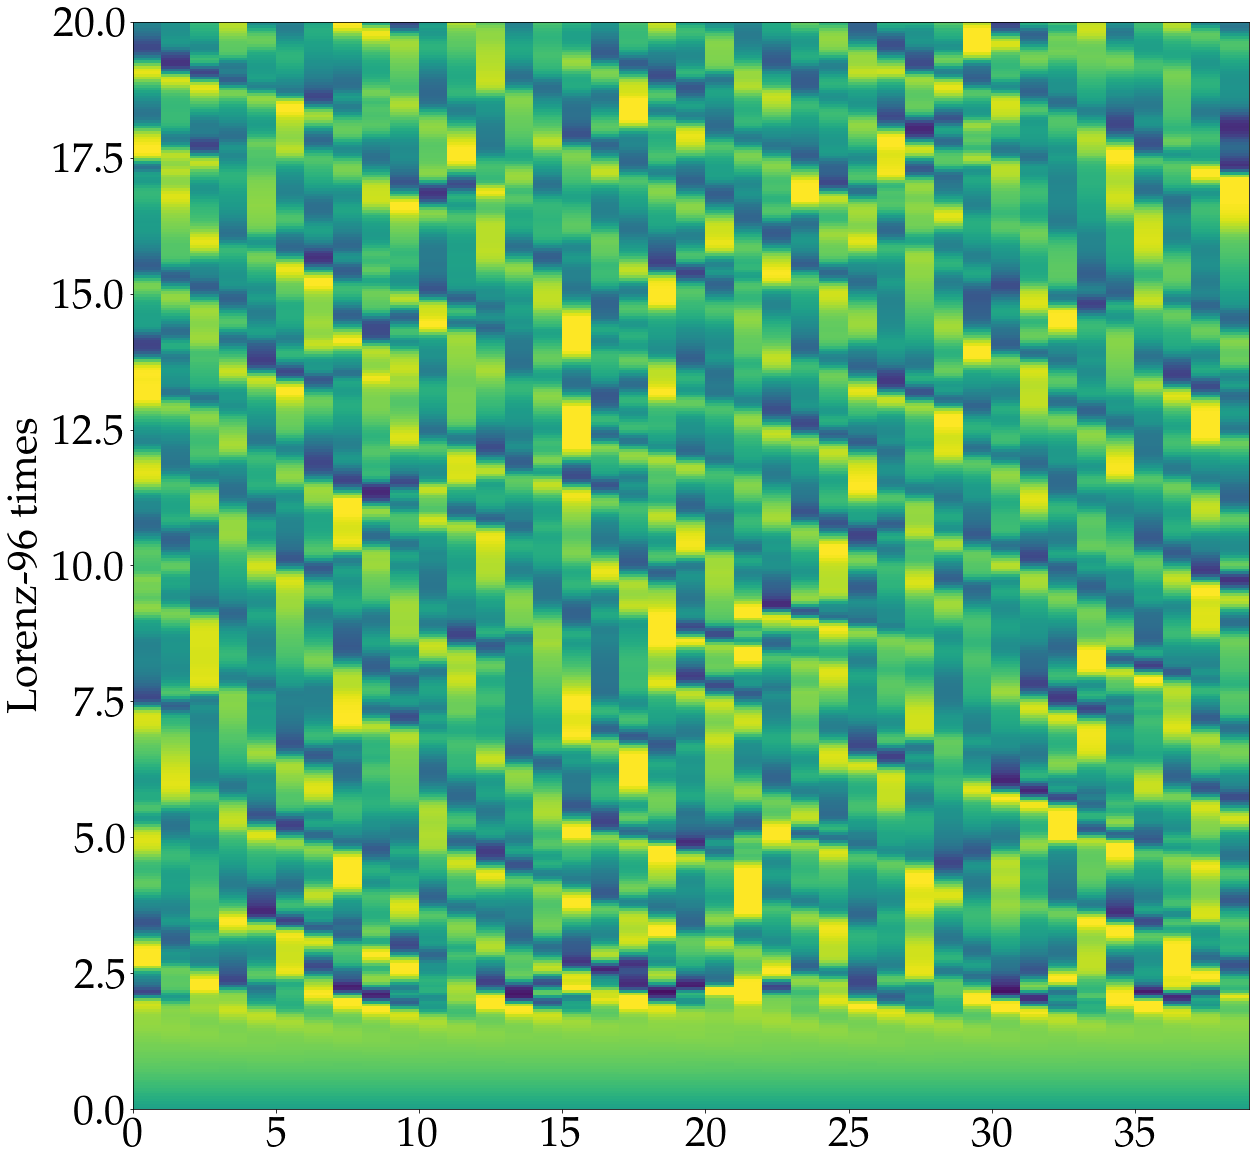

In [48]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(5,5))
[X,Y]= np.meshgrid(range(40),np.linspace(0,nb_steps_pred*0.05,nb_steps_pred+1))
plt.figure(figsize=(20,20))
plt.pcolor(X,Y,y_pred);
plt.xlim([0,40-1]);
plt.clim([-10,10]);
plt.ylabel('Lorenz-96 times');

# Comparing results to Adams and RK45 integrations

In [49]:
nb_steps_pred = 400
t_pred = nb_steps_pred * GD.dt_integration
y_pred_RK45=np.zeros((nb_steps_pred,40))
tmp = np.ones((1,40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp[0,20:] = 1+0.01
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred_RK45[i,:] = modelRINN_NL.flow_RK45_True_Model_L96(tmp,0.05,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_RK45[i,:] ,(1,40))).float())

In [50]:
x0 = np.ones((40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
x0[20:] = 1+0.01
S = odeint(Lorenz_96,x0,np.arange(0.0,20+0.000001,0.05),args=(8.0,40));     

<Figure size 360x360 with 0 Axes>

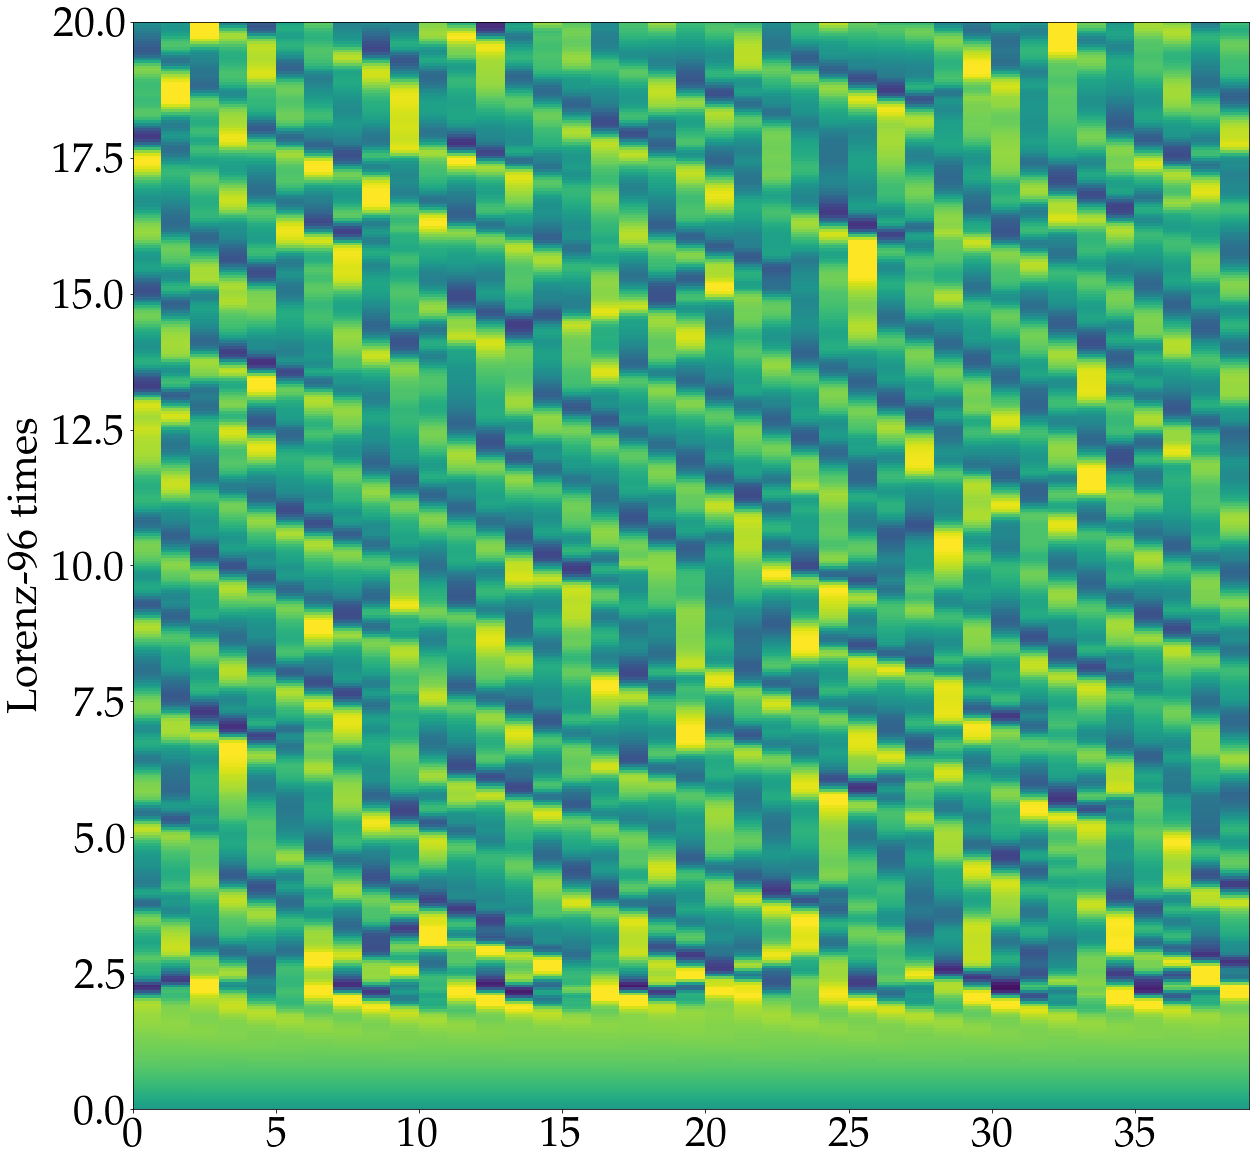

In [51]:
nb_steps_pred
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(5,5))
[X,Y]= np.meshgrid(range(40),np.linspace(0,nb_steps_pred*0.05,nb_steps_pred+1))
plt.figure(figsize=(20,20))
plt.pcolor(X,Y,S);
plt.xlim([0,40-1]);
plt.clim([-10,10]);
plt.ylabel('Lorenz-96 times');

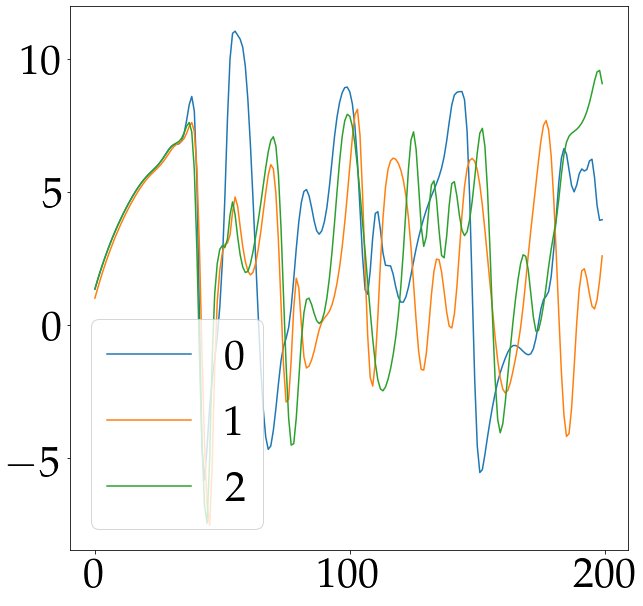

In [52]:
nb_steps_pred
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(10,10))
plt.plot(y_pred[:200,0],label = '0')
plt.plot(S[:200,0],label = '1')
plt.plot(y_pred_RK45[:200,0],label = '2')
plt.legend()

# Testing the Trained Integration scheme on the Non-Linear 63 equation

In [53]:
nb_steps_pred =20000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_L63=np.zeros((nb_steps_pred,3))
tmp = np.ones((1,3))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in tqdm(range(nb_steps_pred)):
    y_pred_L63[i,:] = modelRINN_NL.flow_RINN_True_Model_L63(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_L63[i,:] ,(1,3))).float())

100%|██████████| 20000/20000 [01:58<00:00, 168.51it/s]


Text(0.5, 0, '$z_3$')

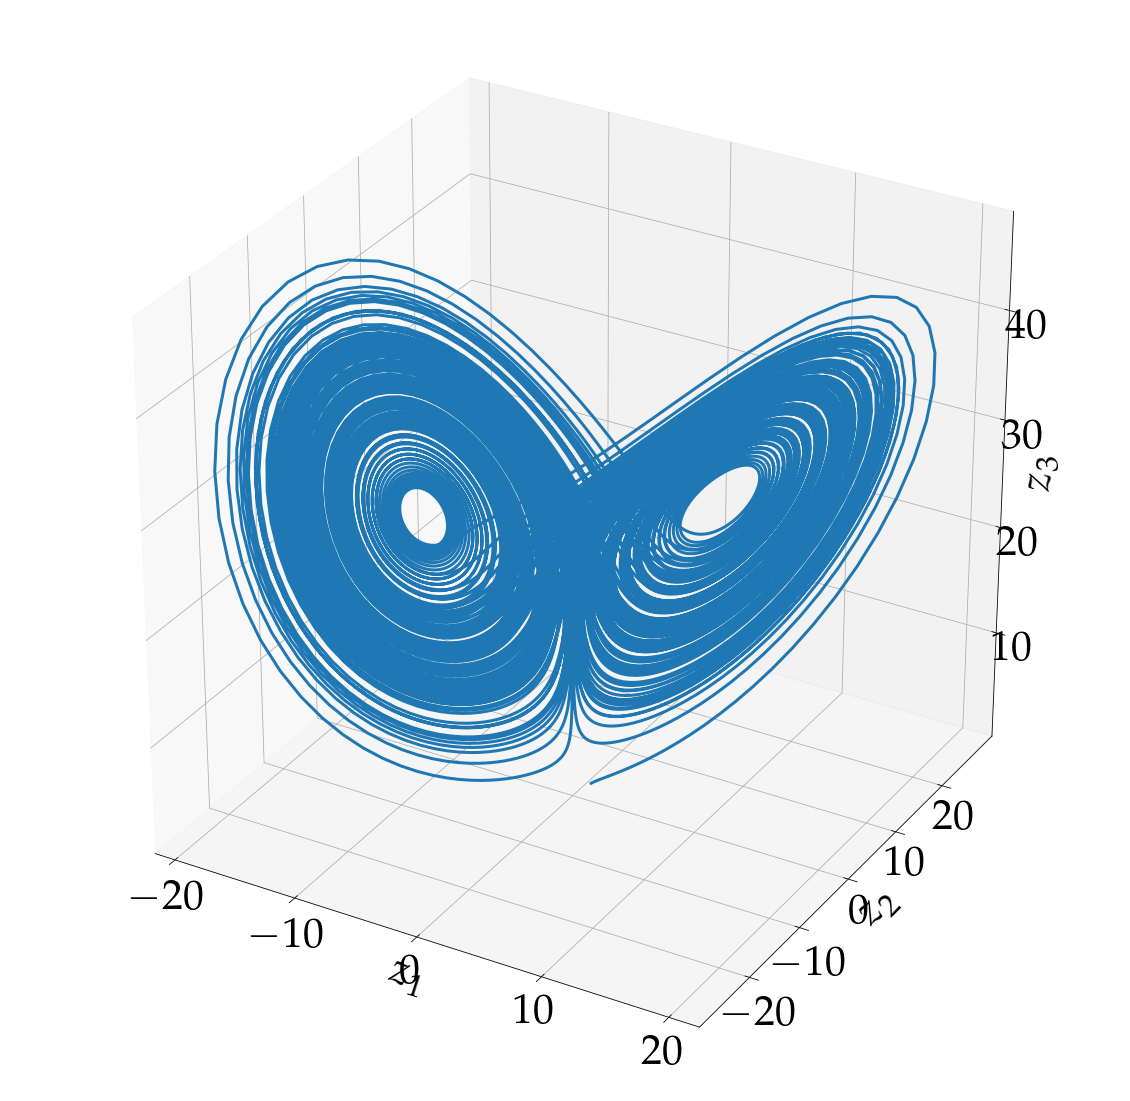

In [54]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred_L63[:,0],y_pred_L63[:,1],y_pred_L63[:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)

# Comparing results to the Adams and RK45 integrations

In [55]:
nb_steps_pred = 3000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_L63_RK4=np.zeros((nb_steps_pred,3))
tmp = np.ones((1,3))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in tqdm(range(nb_steps_pred)):
    y_pred_L63_RK4[i,:] = modelRINN_NL.flow_RK45_L63(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_L63_RK4[i,:] ,(1,3))).float())

100%|██████████| 3000/3000 [00:01<00:00, 1905.39it/s]


In [56]:
x0 = np.ones((3))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
S = odeint(Lorenz_63,x0,np.arange(0.0,200+0.000001,0.01),args=(10.0, 28.0, 8.0/3));     

Text(0.5, 0, '$z_3$')

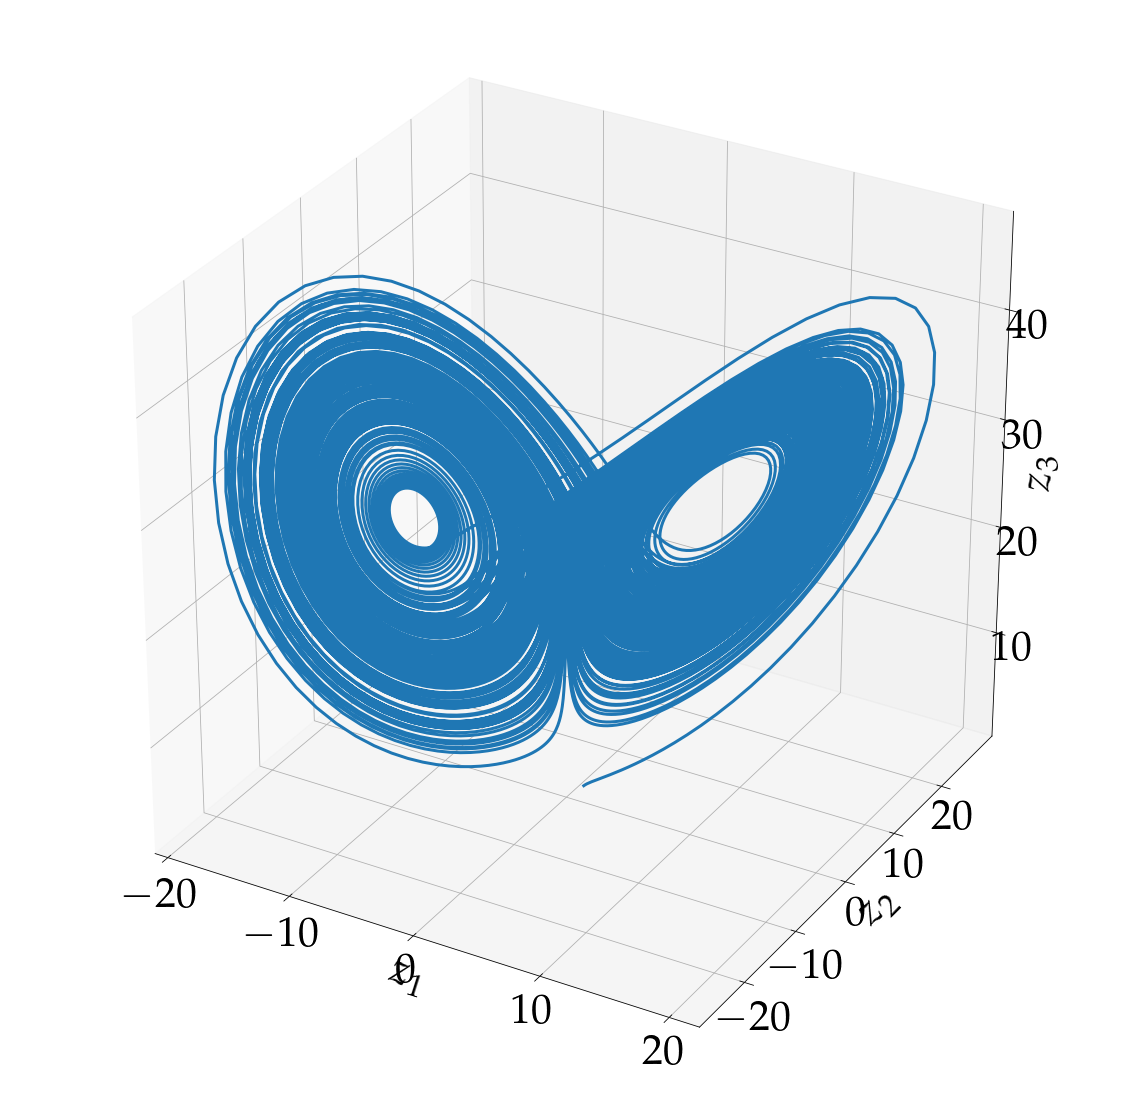

In [57]:
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(S[:,0],S[:,1],S[:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)

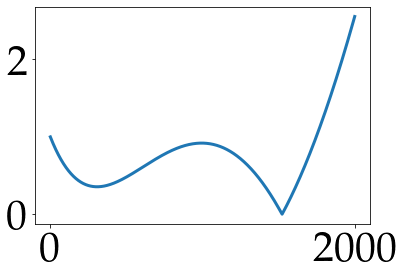

In [58]:
plt.plot(gain_opti_const[:],label = 'RINN 12',lw = 3)